In [1]:
import numpy as np 
import sklearn
import sklearn.model_selection

inputs = [] 
labels = []
with open("seeds_dataset.txt", "r") as f:
    for line in f:
        inputs.append([float(val) for val in line.strip().split()[:7]])
        labels.append(int(line.strip().split()[7]))

inputs = np.array(inputs, dtype=float)
labels = np.array(labels)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(inputs, labels, train_size=0.8, shuffle=True)

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(X):
    sigmoid_output = sigmoid(X)
    return sigmoid_output * (1 - sigmoid_output)

def relu(X):
    return np.maximum(0, X)

def relu_deriv(X):
    return X > 0

def get_expected_from_label(label):
    expected = np.zeros(3)
    expected[label - 1] = 1.0
    return expected

def mean_squared_error(output, expected_label):
    expected = get_expected_from_label(expected_label)    

    return np.mean((expected - output) ** 2)

def msq_deriv(output, expected_label):
    expected = get_expected_from_label(expected_label)
    return output - expected

class Layer:
    def __init__(self, m, n, activation_func):
        #n - nr de neuroni de pe stratul x
        #m - nr de neuroni de pe stratul x - 1
        self.weight = np.random.rand(n, m) - 0.5
        self.bias = np.random.rand(n) - 0.5
        self.activation = activation_func
    
    def activate(self, neurons):
        return self.activation(neurons)
    

In [3]:
alfa = 0.01 #learning rate
epochs = 1000

epoch_error = {} #eroare la antrenare si testare pt fiecare epoca, pentru bonus

# 2 straturi ascunse de cate 5 neuroni fiecare.
# Activare - ReLU pe straturile ascunse, sigmoid pe cel de output
layers = [Layer(7, 5, relu), Layer(5, 5, relu), Layer(5, 3, sigmoid)]

In [6]:

def compute_output(input, layer):
    output = np.dot(layer.weight, input) + layer.bias
    return layer.activate(output)

def feed_forward(input, label, layers):
    output = None
    for layer in layers:
        output = compute_output(input, layer)
        input = output
    # print(output)
    # print(f"Expected: {label}; Prediction: {np.argmax(output) + 1} ")
    # print(get_expected_from_label(label))
    # print(f"MSE: {mean_squared_error(output, label)}")

    return np.argmax(output) + 1

def backpropagate(input, label, layers):
    delta_weights = [np.zeros(layer.weight.shape) for layer in layers]
    delta_biases = [np.zeros(layer.bias.shape) for layer in layers]

    neurons_a = [input] #neuronii activati

    for layer in layers:
        output_a = compute_output(input, layer)
        neurons_a.append(output_a)
        input = output_a

    delta = None
    for i in range(len(layers) - 1, -1, -1):
        if i == len(layers) - 1: #sunt pe ultimul strat
            delta = msq_deriv(neurons_a[-1], label) * sigmoid_deriv(neurons_a[-1])
        else:
            delta = np.dot(layers[i + 1].weight.T, delta) * relu_deriv(neurons_a[i + 1])

        delta_biases[i] = delta 
        delta_weights[i] = np.outer(delta, neurons_a[i])

    return delta_weights, delta_biases

def train(x_train, y_train, layers, epochs, alfa):
    iteration = 0
    while iteration < epochs:
        for i in range(len(x_train)):
            input_data = x_train[i]
            label = y_train[i]

            #backpropagation
            delta_weights, delta_biases = backpropagate(input_data, label, layers)

            #update weights and biases
            for i, layer in enumerate(layers):
               layer.weight -= alfa * delta_weights[i]
               layer.bias -= alfa * delta_biases[i]
        
        #pentru bonus
        train_error = 1 - predict(x_train, y_train)[1]
        test_error = 1 - predict(x_test, y_test)[1]
        epoch_error[iteration] = (train_error, test_error)
        #

        iteration += 1

def predict(x_set, y_set):
    correct_count = 0
    total_count = 0
    points = [] #setul de date ca puncte in 2d + true/false daca e eroare; pentru bonus
    for x, y in zip(x_set, y_set):
        predicted = feed_forward(x, y, layers)
        total_count += 1
        points.append((x[:2], False))

        if predicted == y:
            correct_count += 1
            points[-1] = (x[:2], True)


    return points, correct_count / total_count

In [7]:
train(x_train, y_train, layers, epochs, alfa)

In [8]:
train_points, train_acc = predict(x_train, y_train)
test_points, test_acc = predict(x_test, y_test)

In [9]:
print(f"Test accuracy: {test_acc * 100}%")
print(f"Train accuracy: {train_acc * 100}%")

Test accuracy: 90.47619047619048%
Train accuracy: 97.02380952380952%


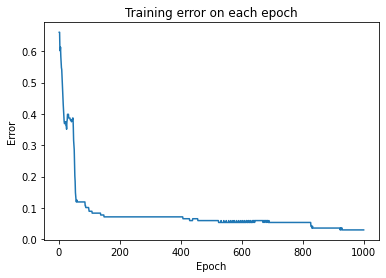

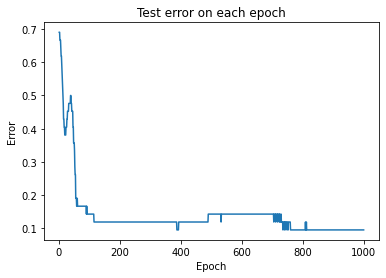

In [14]:
import matplotlib.pyplot as plot

def show_plot(errors, epochs, title):
    plt = plot
    plt.plot(np.arange(1, epochs + 1), errors)

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.show()


show_plot([train_err for train_err, _ in epoch_error.values()], epochs, "Training error on each epoch")
show_plot([test_err for _, test_err in epoch_error.values()], epochs, "Test error on each epoch")

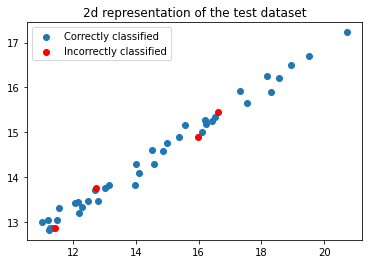

In [19]:
plt = plot

plt.scatter([test_point[0][0] for test_point in test_points if test_point[1] is True],
            [test_point[0][1] for test_point in test_points if test_point[1] is True], 
            label="Correctly classified")

plt.scatter([test_point[0][0] for test_point in test_points if test_point[1] is False],
            [test_point[0][1] for test_point in test_points if test_point[1] is False],
            color="red",
            label="Incorrectly classified")

plt.title("2d representation of the test dataset")
plt.legend()
